In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
customers_path = "Customers.csv"
transactions_path = "Transactions.csv"

In [3]:
customers_df = pd.read_csv(customers_path)
transactions_df = pd.read_csv(transactions_path)

In [4]:
# Merge the datasets
merged_df = pd.merge(transactions_df, customers_df, on="CustomerID", how="inner")

In [5]:
# Convert TransactionDate and SignupDate to datetime
merged_df['TransactionDate'] = pd.to_datetime(merged_df['TransactionDate'])
merged_df['SignupDate'] = pd.to_datetime(merged_df['SignupDate'])

In [6]:
# Feature Engineering: Aggregating customer data
customer_features = merged_df.groupby('CustomerID').agg(
    total_spending=('TotalValue', 'sum'),
    avg_transaction_value=('TotalValue', 'mean'),
    transaction_count=('TransactionID', 'count'),
    avg_items_per_transaction=('Quantity', 'mean'),
    customer_tenure_days=('SignupDate', lambda x: (pd.Timestamp.now() - x.min()).days)
).reset_index()

In [7]:
# Selecting the features for clustering
features = customer_features[
    ['total_spending', 'avg_transaction_value', 'transaction_count',
     'avg_items_per_transaction', 'customer_tenure_days']
]

In [8]:
# Standardizing the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [9]:
# Perform clustering using K-Means for a range of clusters (2 to 10)
db_scores = {}
cluster_results = {}

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_features)

    # Calculate Davies-Bouldin Index
    db_index = davies_bouldin_score(scaled_features, cluster_labels)
    db_scores[n_clusters] = db_index
    cluster_results[n_clusters] = cluster_labels

In [10]:
# Find the optimal number of clusters based on the lowest DB Index
optimal_clusters = min(db_scores, key=db_scores.get)
optimal_db_index = db_scores[optimal_clusters]


In [11]:
print(f"Optimal number of clusters: {optimal_clusters}")
print(f"Davies-Bouldin Index for optimal clusters: {optimal_db_index}")

Optimal number of clusters: 9
Davies-Bouldin Index for optimal clusters: 1.1145016591939396


In [12]:
# Add cluster labels to the original dataset
customer_features['Cluster'] = cluster_results[optimal_clusters]

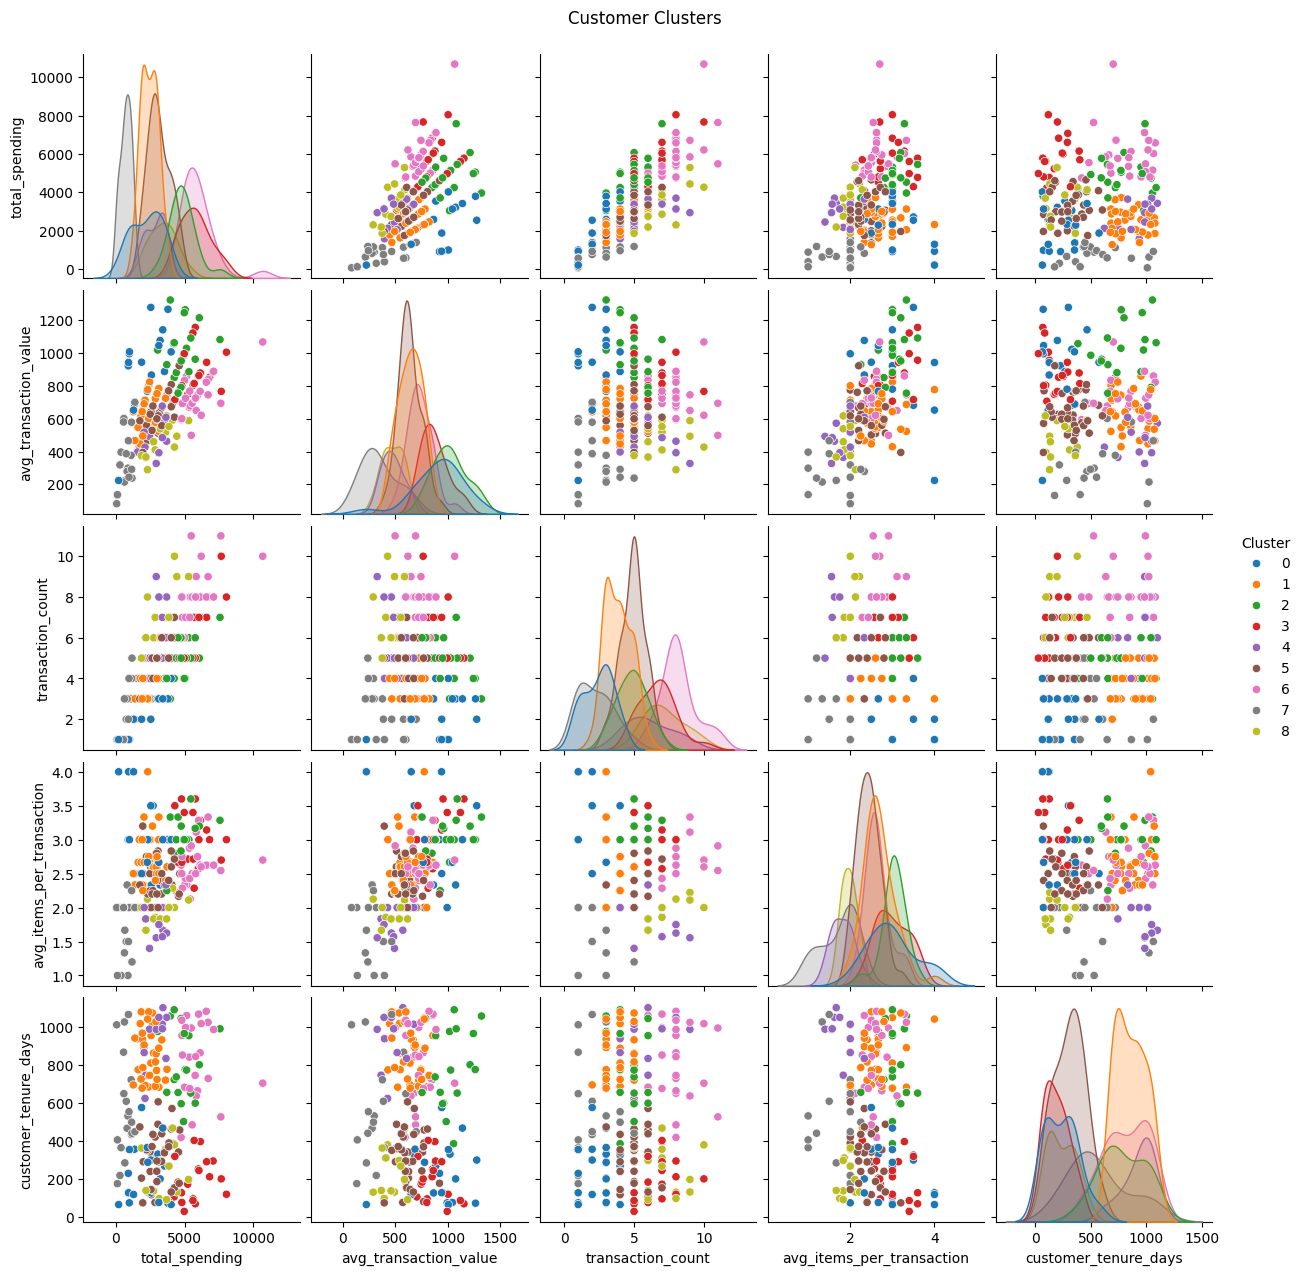

In [13]:
# Visualizing the clusters
sns.pairplot(customer_features, hue='Cluster', diag_kind='kde', palette='tab10')
plt.suptitle("Customer Clusters", y=1.02)
plt.show()

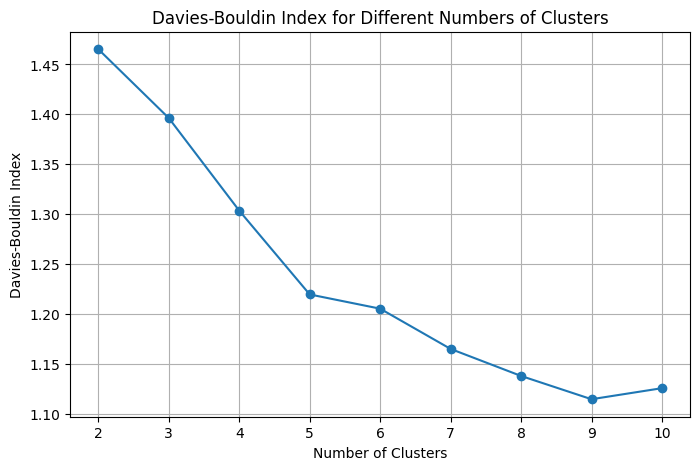

In [14]:
# Plot Davies-Bouldin Index for each number of clusters
plt.figure(figsize=(8, 5))
plt.plot(list(db_scores.keys()), list(db_scores.values()), marker='o')
plt.title('Davies-Bouldin Index for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(range(2, 11))
plt.grid()
plt.show()

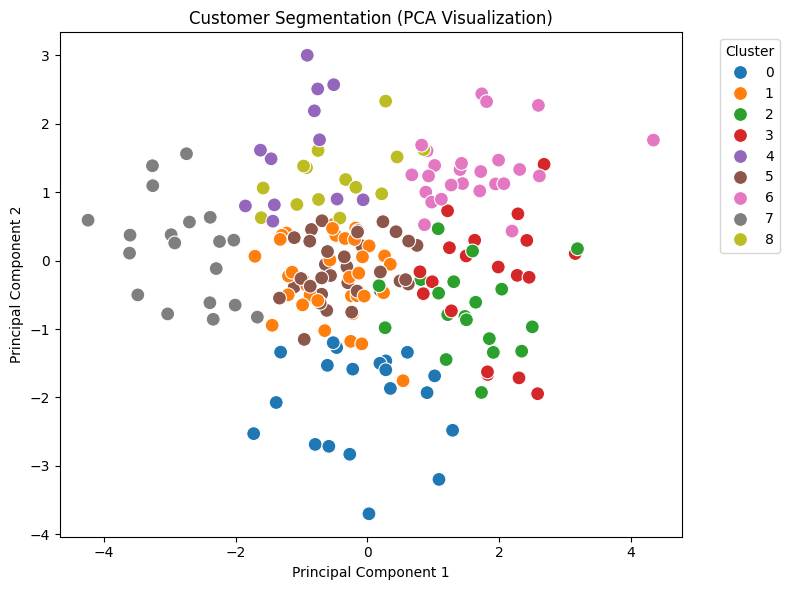

In [16]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

# Add PCA components and cluster labels for visualization
customer_features['PCA1'] = pca_features[:, 0]
customer_features['PCA2'] = pca_features[:, 1]

# Scatter plot of clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=customer_features, palette='tab10', s=100
)
plt.title('Customer Segmentation (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [17]:
# Save customer features with cluster labels
customer_features.to_csv("customer_segmentation_results.csv", index=False)
print("Customer segmentation results saved as 'customer_segmentation_results.csv'")


Customer segmentation results saved as 'customer_segmentation_results.csv'
